In [118]:
import pandas as pd 
import numpy as np
from skimage import io, color, filters, feature
import matplotlib.pyplot as plt

In [117]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('data/age_gender.csv')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [6]:
type(df['pixels'][0])

str

In [7]:
df['pixels'][0][0:10]

'129 128 12'

In [8]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [122]:
X = np.array(df['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48)

In [10]:
X.shape

(23705, 48, 48)

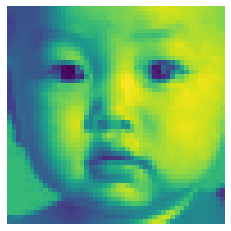

In [11]:
plt.imshow(X[2].reshape(48,48))
plt.axis('off')
plt.show()

__Ethnicity is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).__

In [12]:
df['gender_str']=df['gender'].map({1:'Female',0:'Male'})
df['ethnicity_str']=df['ethnicity'].map({0:'White',1:'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'})

In [13]:
np.random.randint(0, len(X), 1)[0]

17250

In [14]:
np.array(df['age'])

array([ 1,  1,  1, ..., 99, 99, 99])

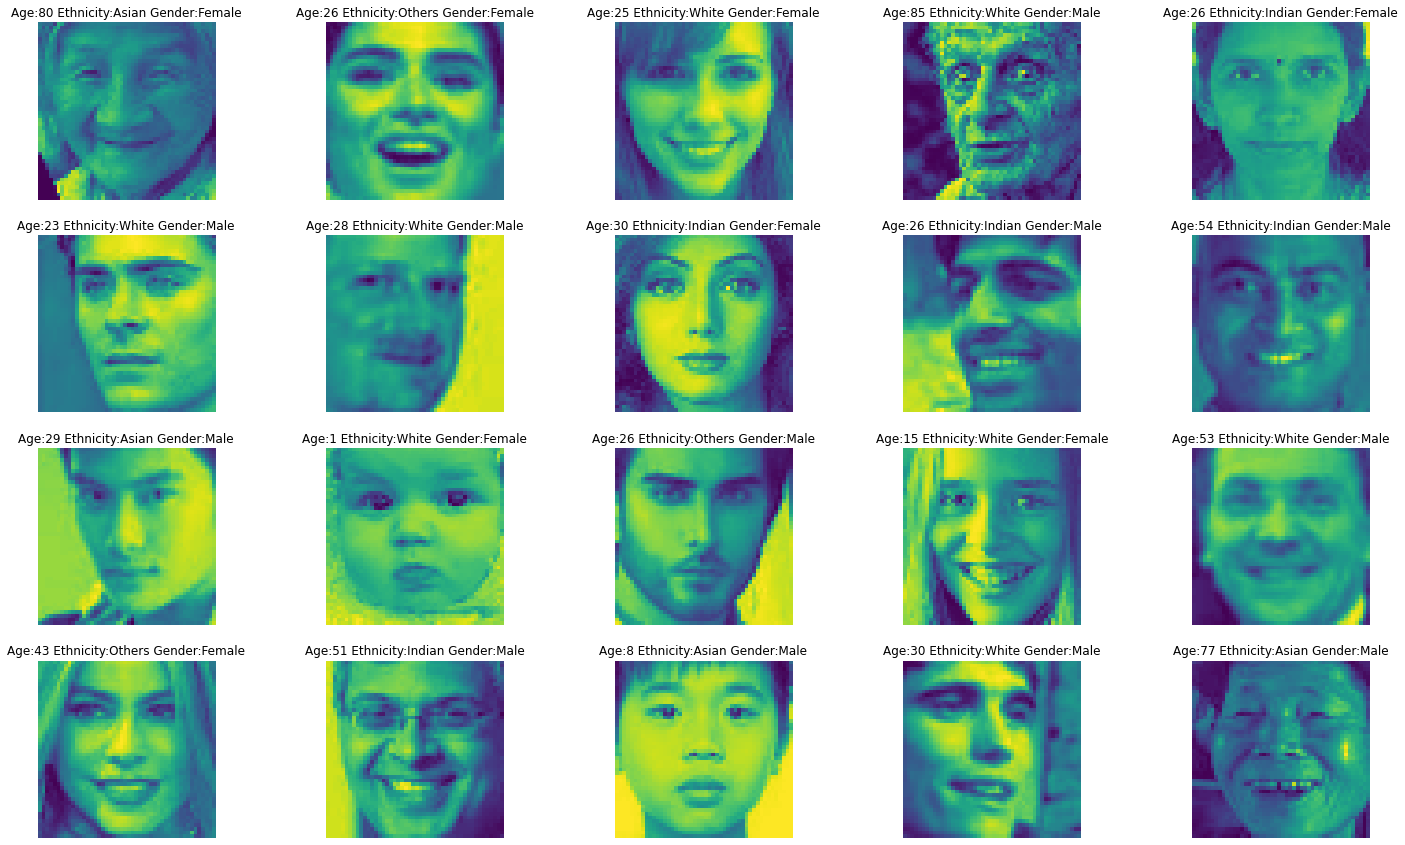

In [123]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(X), 1)
    ax.imshow(X[i][0])
    ax.set_title(
 "Age:"+str(np.array(df['age'])[i][0])+" Ethnicity:"+str(np.array(df['ethnicity_str'])[i][0])+" Gender:"+str(np.array(df['gender_str'])[i][0])    )
    ax.axis('off')
plt.show()

In [16]:
df['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

# EDA

## __Age__

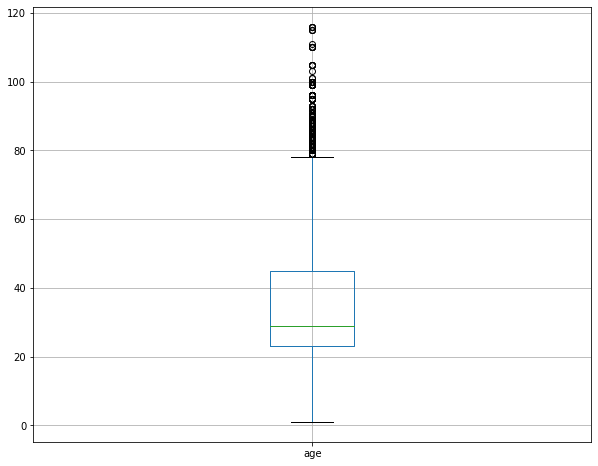

In [17]:
df[['age']].boxplot(figsize=(10,8));

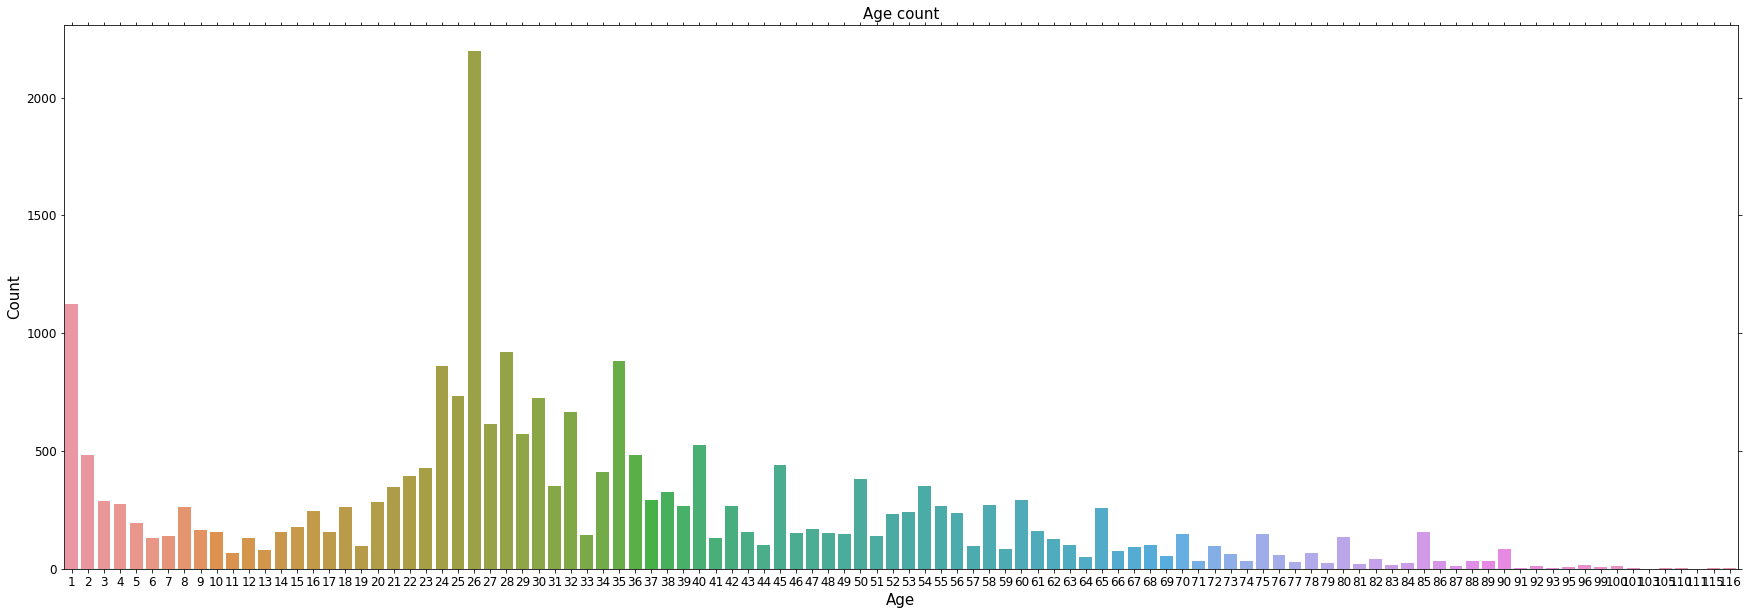

In [18]:
plt.figure(figsize=(30,10))
ax=sns.countplot(df['age'])
ax.set_title("Age count", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12, reset= True)

## __Gender__

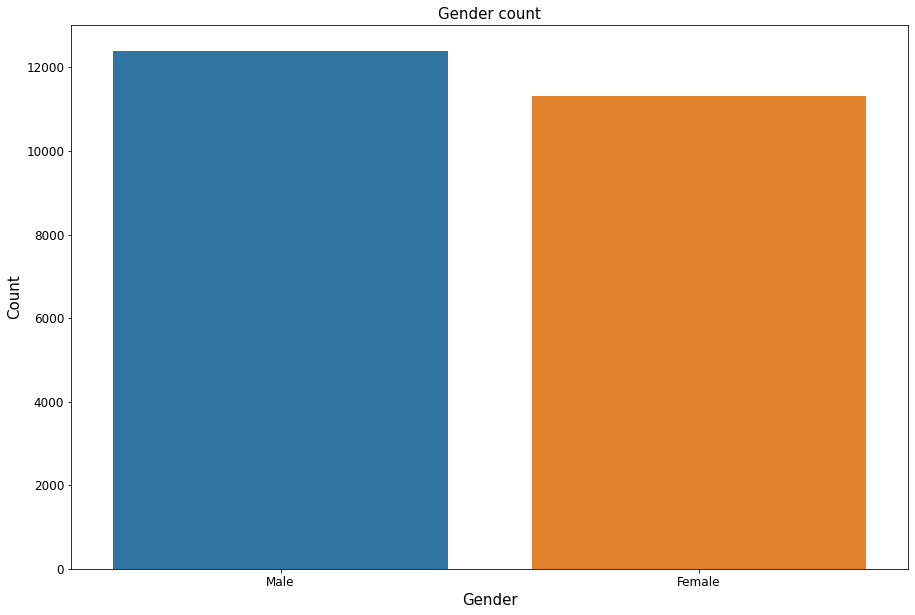

In [19]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['gender_str'])
ax.set_title("Gender count", size=15)
ax.set_xlabel("Gender", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

## __Ethnicity__

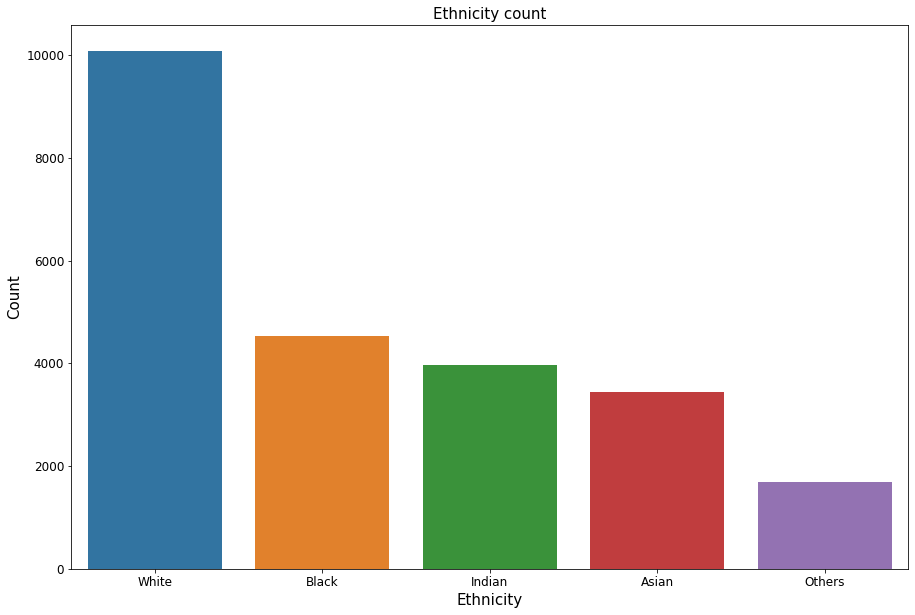

In [20]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['ethnicity_str'], order=df['ethnicity_str'].value_counts().index)
ax.set_title("Ethnicity count", size=15)
ax.set_xlabel("Ethnicity", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

In [21]:
X.shape

(23705, 48, 48)

In [22]:
y_gender=np.array(df.gender)
y_gender.shape
y_ethnicity=np.array(df.ethnicity)
y_ethnicity.shape
y_age=np.array(df.age)
y_age.shape

(23705,)

__Model Building__

In [23]:
import tensorflow as tf
import tensorflow.keras.layers as L

In [24]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [27]:
X=X.reshape(X.shape[0],48,48,1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_gender, test_size=0.25, random_state=37)

In [29]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

model.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


## Stop training when validation loss reach 0.2700
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.2700):
            print("\nReached 0.2700 val_loss so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [36]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=16, validation_data=(X_test, y_test) ,callbacks=[callback]
)

Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0867 - accuracy: 0.9654 - val_loss: 0.3012 - val_accuracy: 0.8931
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.0824 - accuracy: 0.9667 - val_loss: 0.4061 - val_accuracy: 0.8886
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.9696 - val_loss: 0.3857 - val_accuracy: 0.8976
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0714 - accuracy: 0.9719 - val_loss: 0.3590 - val_accuracy: 0.8982
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0702 - accuracy: 0.9729 - val_loss: 0.3419 - val_accuracy: 0.8971
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0673 - accuracy: 0.9736 - val_loss: 0.3961 - val_accuracy: 0.8948
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0632 - accuracy: 0.9756 - val_loss: 0.3852 - val_accuracy:

In [303]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [34]:
score = model.evaluate(X_test, y_test, verbose=0)

In [35]:
print('Test score:', score[0])
print('Test accuracy:', score[1]) # this is the one we care about

Test score: 0.32401591539382935
Test accuracy: 0.8932006359100342


In [39]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy'):
    
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [53]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy')

In [55]:
gender_history = gender_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/20
2223/2223 [==============================] - 7s 3ms/step - loss: 0.0195 - accuracy: 0.9940 - val_loss: 0.5197 - val_accuracy: 0.8919
Epoch 2/20
2223/2223 [==============================] - 7s 3ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.5453 - val_accuracy: 0.8917
Epoch 3/20
2223/2223 [==============================] - 5s 2ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.5793 - val_accuracy: 0.8930
Epoch 4/20
2223/2223 [==============================] - 5s 2ms/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 0.5832 - val_accuracy: 0.8893
Epoch 5/20
2223/2223 [==============================] - 5s 2ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.6300 - val_accuracy: 0.8934
Epoch 6/20
2223/2223 [==============================] - 5s 2ms/step - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.6313 - val_accuracy: 0.8927
Epoch 7/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.0100 - accuracy: 0.9968 - val_loss: 0.6747 - val_accuracy:

In [49]:
#gender_history.history

In [50]:
X_train.shape

(17778, 48, 48, 1)

In [56]:
gender_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)       

In [58]:
y_pred=gender_model.predict(X_test)

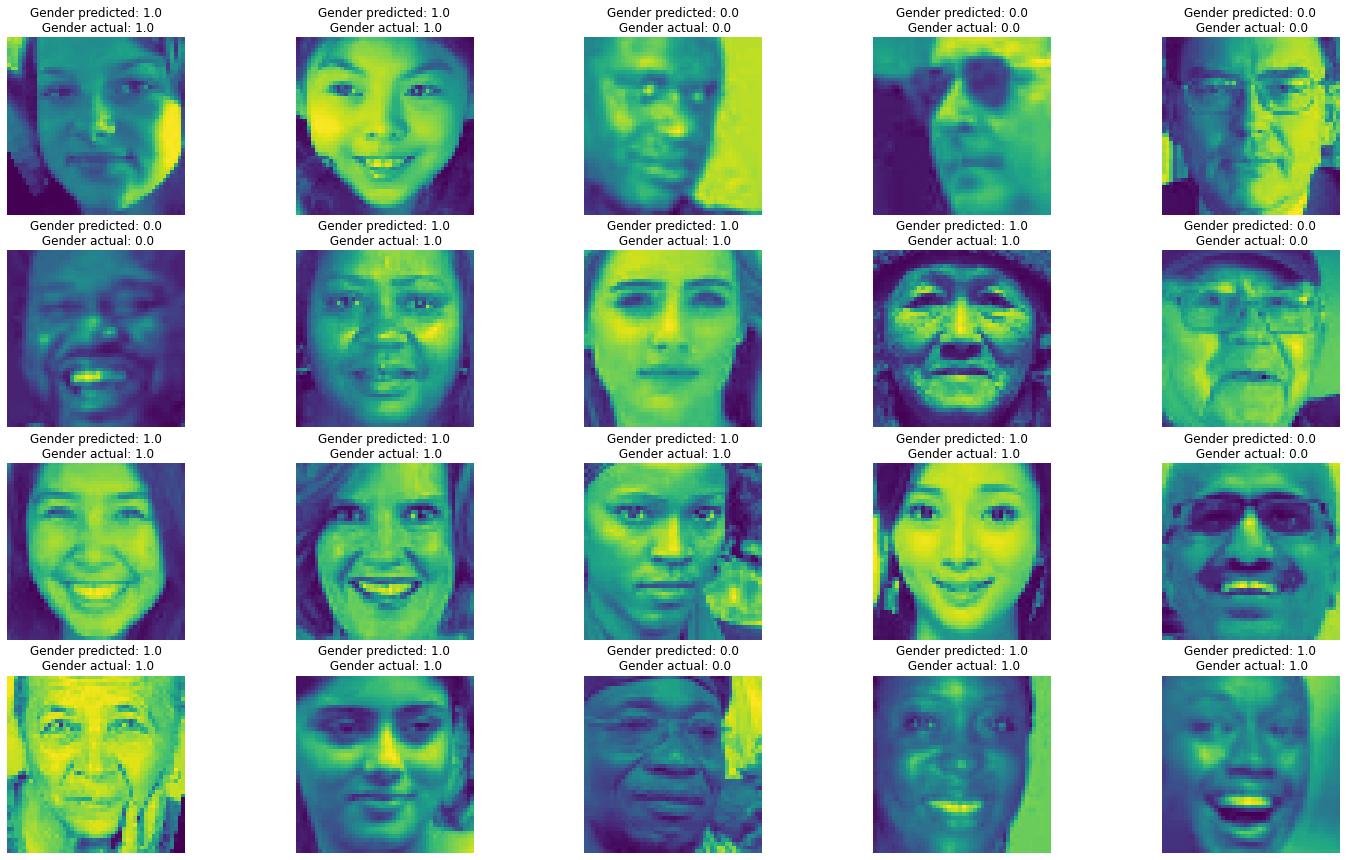

In [163]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(y_test),1)
    X_plot=X_test[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_pred[i][0][0]))+ "\n Gender actual: "+str(round(y_pred[i][0][0] )))
    #ax.set_title( )
    ax.axis('off')
plt.show()